In [1]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)



1.11.0+cpu
0.11.0+cpu
cpu


In [2]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

### Creating a pipeline
First, we will create a Wav2Vec2 model that performs the feature extraction and the classification.

There are two types of Wav2Vec2 pre-trained weights available in torchaudio. The ones fine-tuned for ASR task, and the ones not fine-tuned.

Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They are firstly trained with audio only for representation learning, then fine-tuned for a specific task with additional labels.

The pre-trained weights without fine-tuning can be fine-tuned for other downstream tasks as well, but this tutorial does not cover that.

### We will use torchaudio.pipelines.VOXPOPULI_ASR_BASE_10K_IT () here.

There are multiple models available as torchaudio.pipelines. Please check the documentation for the detail of how they are trained.

The bundle object provides the interface to instantiate model and other information. Sampling rate and the class labels are found as follow.

In [3]:
bundle = torchaudio.pipelines.VOXPOPULI_ASR_BASE_10K_IT

print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'e', 'i', 'a', 'o', 'n', 't', 'r', 'l', 's', 'c', 'd', 'u', 'p', 'm', 'g', 'v', 'h', 'z', 'f', 'b', 'q', 'à', 'è', 'ù', 'é', 'ò', 'ì', 'k', 'y', 'x', 'w', 'j', 'ó', 'í', 'ï')


Model can be constructed as following. This process will automatically fetch the pre-trained weights and load it into the model.


In [4]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_voxpopuli_base_10k_asr_it.pt" to C:\Users\User/.cache\torch\hub\checkpoints\wav2vec2_voxpopuli_base_10k_asr_it.pt


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


### Loading data
We will use the speech data from VOiCES dataset, which is licensed under Creative Commos BY 4.0.



In [5]:
IPython.display.Audio(SPEECH_FILE)

To load data, we use torchaudio.load().

If the sampling rate is different from what the pipeline expects, then we can use torchaudio.functional.resample() for resampling.

 -- torchaudio.functional.resample() works on CUDA tensors as well.
 
 -- When performing resampling multiple times on the same set of sample rates, using torchaudio.transforms.Resample() might improve the performace.


In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
print("Waveform shape: {} - Sample Rate: {}".format(waveform.shape, sample_rate))
# RESAMPLE WAVEFORM TO THE SAME SAMPLE RATE OF USED NETWORK
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

Waveform shape: torch.Size([1, 54400]) - Sample Rate: 16000


## Extracting acoustic features
The next step is to extract acoustic features from the audio.

### NOTE

Wav2Vec2 models fine-tuned for ASR task can perform feature extraction and classification with one step, but for the sake of the tutorial, we also show how to perform feature extraction here.


In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

print("features:{}, ".format(len(features)))

features:12, 


The returned features is a list of tensors. Each tensor is the output of a transformer layer.

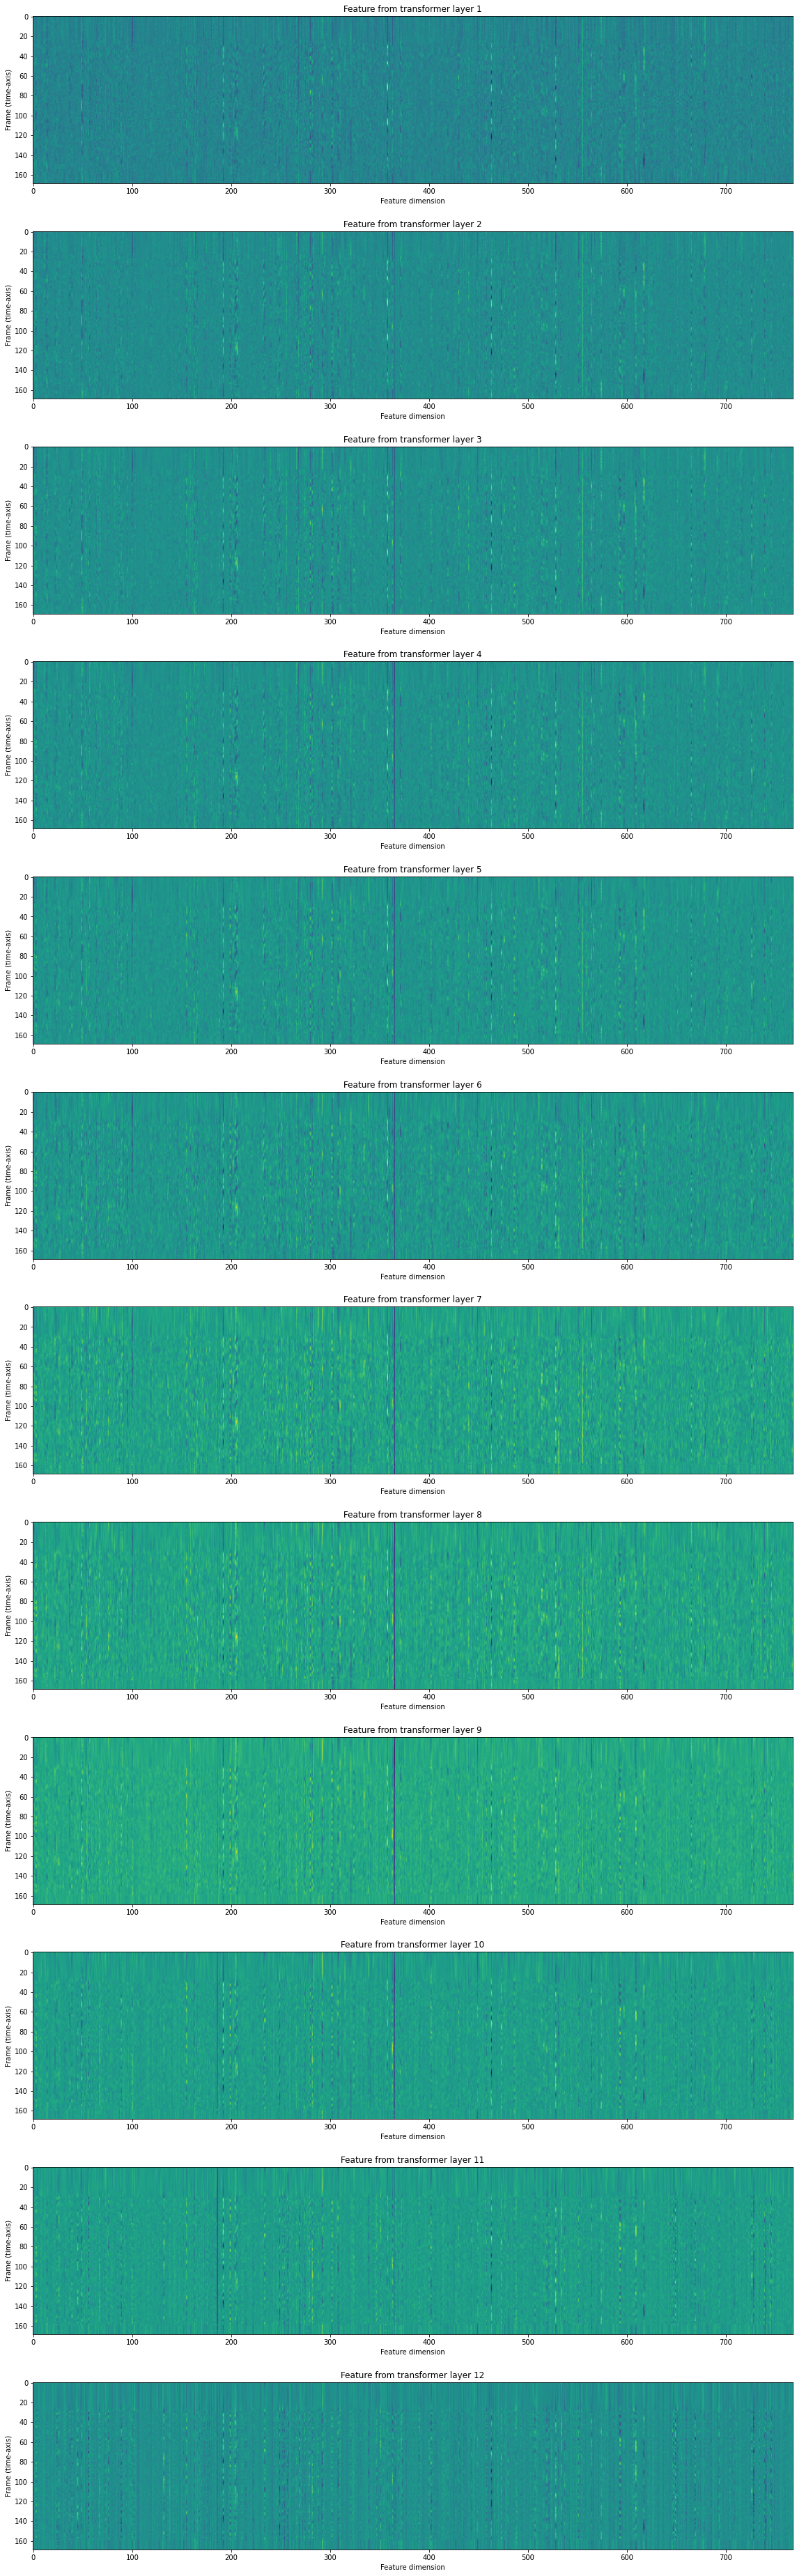

In [8]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

## Feature classification
Once the acoustic features are extracted, the next step is to classify them into a set of categories.

Wav2Vec2 model provides method to perform the feature extraction and classification in one step.



In [9]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of probability.

Let’s visualize this.

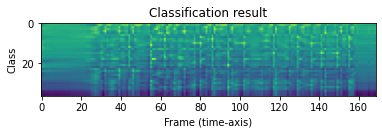

In [10]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()


In [11]:
print("Class labels:", bundle.get_labels())

Class labels: ('-', '|', 'e', 'i', 'a', 'o', 'n', 't', 'r', 'l', 's', 'c', 'd', 'u', 'p', 'm', 'g', 'v', 'h', 'z', 'f', 'b', 'q', 'à', 'è', 'ù', 'é', 'ò', 'ì', 'k', 'y', 'x', 'w', 'j', 'ó', 'í', 'ï')


We can see that there are strong indications to certain labels across the time line.



### Generating transcripts
From the sequence of label probabilities, now we want to generate transcripts. The process to generate hypotheses is often called “decoding”.

Decoding is more elaborate than simple classification because decoding at certain time step can be affected by surrounding observations.

For example, take a word like night and knight. Even if their prior probability distribution are differnt (in typical conversations, night would occur way more often than knight), to accurately generate transcripts with knight, such as a knight with a sword, the decoding process has to postpone the final decision until it sees enough context.

There are many decoding techniques proposed, and they require external resources, such as word dictionary and language models.

In this tutorial, for the sake of simplicity, we will perform greedy decoding which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.

We start by defining greedy decoding algorithm.

In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [13]:
# Now create the decoder object and decode the transcript.
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [14]:
# Let’s check the result and listen again to the audio.

print(transcript)
IPython.display.Audio(SPEECH_FILE)

aade|chioroiasseribesimietesmomat
